In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from darts import TimeSeries
from darts.metrics import mae, rmse
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Auxiliar functions
from tshelpers.plot import plot_compare
from tshelpers.metrics import mae_score, rmse_score

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks", palette="mako")

/home/erich/projects/Air-We-Breath/.awb/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Reading short imputed master dataframe
master_df = pd.read_csv("data/2016_2021_master_df_short_imputed.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


(228056, 5)


In [4]:
# Redefining experimentation subsets to 2 months prior training set
stations = master_df["STATION"].unique()
subsets = {}
for station in stations:
    subsets[station] = {}
    for month, year in [(2, 2016), (11, 2017), (10, 2018), (8, 2020)]:
        subsets[station][f"{month}-{year}"] = master_df[master_df["STATION"] == station].loc[
    datetime(year, month-1, 1):datetime(year, month+1, 1), ["PM 2.5"]]

for station in subsets:
    print(station, subsets[station].keys())

# Darts timeseries64
for station in subsets:
    for month in subsets[station]:
        subsets[station][month] = TimeSeries.from_dataframe(subsets[station][month])

Vancouver_Clark_Drive_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
Vancouver_International_Airport_#2_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Mahon_Park_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Second_Narrows_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])


In [5]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"]
subset = station_subset.loc[datetime(2020, 7, 1):datetime(2020, 9, 1), "PM 2.5"]
series = TimeSeries.from_dataframe(subset.to_frame().interpolate())

train, val = series.split_before(pd.Timestamp(datetime(2020, 8, 15)))

## Creating month, year, and day-of-week covariates
# Year covariates
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(),
                    freq=series.freq_str,
                    periods=len(series)),
    attribute="year",
    one_hot=False,
)

In [6]:
# Past covariates
past_covariates = {}
for year in [2016, 2017, 2018, 2019]:
    past_covariates[year] = station_subset.loc[datetime(year, 7, 1):datetime(year, 9, 1), "PM 2.5"]
    past_covariates[year] = TimeSeries.from_dataframe(past_covariates[year].to_frame().interpolate())

## Past Covariates
Investigating influence of past covariates on training

In [44]:
# LSTM with previous year covariates
start_date = datetime(2020, 7, 1)   # Subset start date
end_date = datetime(2020, 9, 1)     # Subset end date
split_date = datetime(2020, 8, 15)  # Training/Validation split date

results_dict = {}

station_subset = master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"]
subset = station_subset.loc[start_date:end_date, "PM 2.5"]
series = TimeSeries.from_dataframe(subset.to_frame().interpolate())

train, val = series.split_before(pd.Timestamp(split_date))

## Creating month, day-of-week, and hour covariates
# Month covariates
month_series = datetime_attribute_timeseries(
    series, attribute="month", one_hot=True
)

# Weekday covariates
weekday_series = datetime_attribute_timeseries(
    series, attribute="weekday", one_hot=True
)

# Hour covariates
hour_series = datetime_attribute_timeseries(
    series, attribute="hour", one_hot=False
)
# Scaling hour covariates
hour_series = Scaler().fit_transform(hour_series)

# Stacking covariates
covariates = month_series.stack(weekday_series)
covariates = covariates.stack(hour_series)

## Creating previous years covariates
past_covariates = {}
for year in [2019, 2018, 2017, 2016]:
    past_covariates[year] = station_subset.loc[datetime(year, 7, 1):datetime(year, 9, 1), "PM 2.5"]
    print(f"Missing values on {year} covariate: {past_covariates[year].to_frame().isna().sum()}")
    past_covariates[year] = TimeSeries.from_dataframe(past_covariates[year].to_frame().interpolate())

    print(f"Concatenating past covariate for year {year}...")
    covariates = covariates.concatenate(past_covariates[year], axis=1, ignore_time_axis=True)
    cov_train, cov_val = covariates.split_before(pd.Timestamp(split_date))

    model_name = f"LSTM_2020-{year}_covariates"
    results_dict[model_name] = {}

    # Early stopping
    stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.02,
        mode="min"
    )

    # LSTM model
    my_model = RNNModel(
        model="LSTM",
        hidden_dim=200,
        dropout=0.1,
        batch_size=32,
        n_epochs=100,
        optimizer_kwargs={"lr": 5e-4},
        model_name=model_name,
        log_tensorboard=True,
        random_state=123,
        training_length=20,
        input_chunk_length=21,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs={
            "callbacks": [stopper],
            "accelerator": "gpu",
            "devices": -1,
            "auto_select_gpus": True
        }
    )

    # Training
    my_model.fit(
        train,
        future_covariates=covariates,
        val_series=val,
        val_future_covariates=covariates,
        verbose=True,
    )

    # Validation
    pred_val = my_model.predict(n=len(val), future_covariates=covariates)
    my_model.load_from_checkpoint(model_name=model_name, best=True)

    # Storing results
    results_dict[model_name]["covariates"] = covariates
    results_dict[model_name]["train"] = train
    results_dict[model_name]["val"] = val
    results_dict[model_name]["pred_val"] = pred_val
    results_dict[model_name]["MAE"] = mae(pred_val, val)
    results_dict[model_name]["RMSE"] = rmse(pred_val, val)

2022-11-12 21:01:59 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]
2022-11-12 21:01:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-12 21:01:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-12 21:01:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-12 21:01:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-12 21:01:59 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-12 21:01:59 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 179 K 
4 | V             | Linear    

Missing values on 2019 covariate: PM 2.5    16
dtype: int64
Concatenating past covariate for year 2019...
Epoch 28: 100%|██████████| 47/47 [00:00<00:00, 48.98it/s, loss=1.71, v_num=logs, train_loss=1.410, val_loss=4.280]


2022-11-12 21:02:30 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

2022-11-12 21:02:30 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]



Missing values on 2018 covariate: PM 2.5    3
dtype: int64
Concatenating past covariate for year 2018...


2022-11-12 21:02:30 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-12 21:02:30 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-12 21:02:30 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-12 21:02:30 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-12 21:02:30 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-12 21:02:30 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 180 K 
4 | V             | Linear           | 201   
---------------------------------------------------
180 K     Trainable params
0         No

Epoch 26: 100%|██████████| 47/47 [00:00<00:00, 47.41it/s, loss=1.57, v_num=logs, train_loss=1.540, val_loss=5.470]


2022-11-12 21:02:57 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

2022-11-12 21:02:57 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]



Missing values on 2017 covariate: PM 2.5    17
dtype: int64
Concatenating past covariate for year 2017...


2022-11-12 21:02:57 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-12 21:02:57 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-12 21:02:57 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-12 21:02:57 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-12 21:02:57 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-12 21:02:57 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 180 K 
4 | V             | Linear           | 201   
---------------------------------------------------
181 K     Trainable params
0         No

Epoch 30: 100%|██████████| 47/47 [00:00<00:00, 47.09it/s, loss=1.46, v_num=logs, train_loss=1.590, val_loss=5.810]


2022-11-12 21:03:28 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

2022-11-12 21:03:28 pytorch_lightning.trainer.connectors.accelerator_connector INFO: Auto select gpus: [0]



Missing values on 2016 covariate: PM 2.5    26
dtype: int64
Concatenating past covariate for year 2016...


2022-11-12 21:03:29 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-12 21:03:29 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-12 21:03:29 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-12 21:03:29 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-12 21:03:29 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-12 21:03:29 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 181 K 
4 | V             | Linear           | 201   
---------------------------------------------------
181 K     Trainable params
0         No

Epoch 24: 100%|██████████| 47/47 [00:00<00:00, 48.64it/s, loss=1.49, v_num=logs, train_loss=1.050, val_loss=6.260]


2022-11-12 21:03:53 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Plots for model: LSTM_2020-2019_covariates


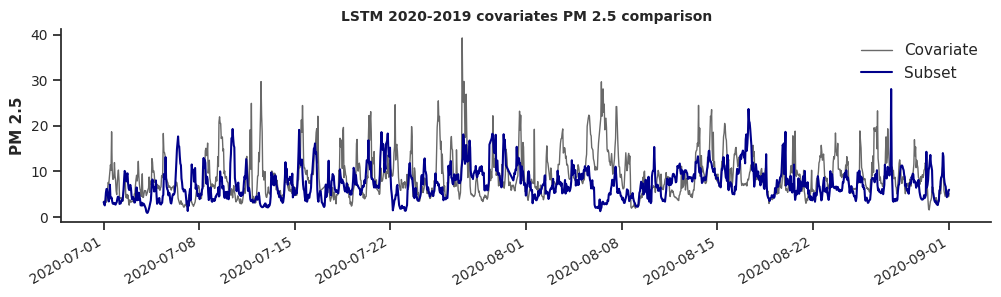

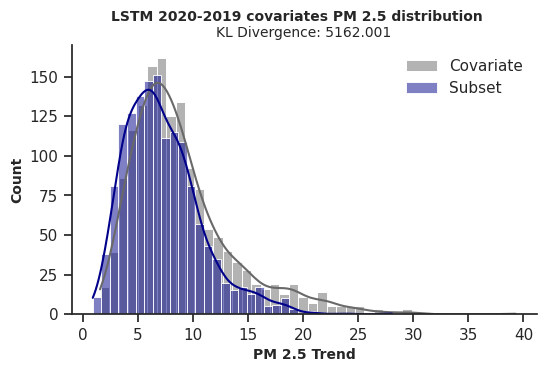

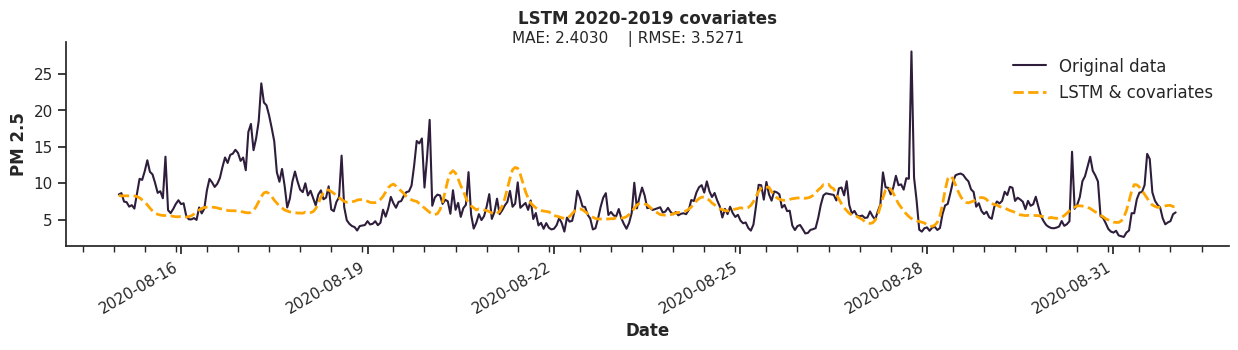

Plots for model: LSTM_2020-2018_covariates


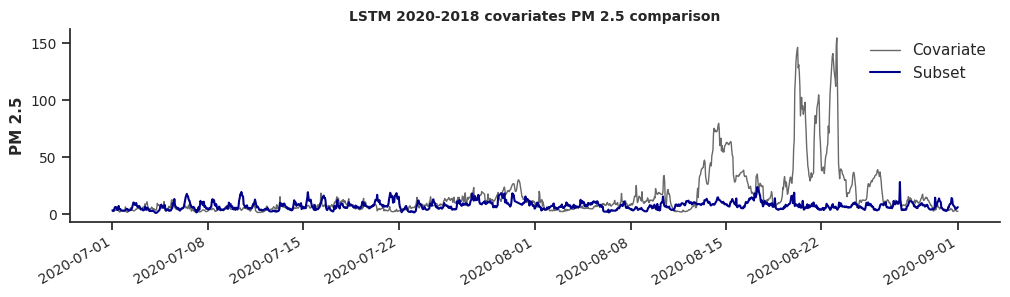

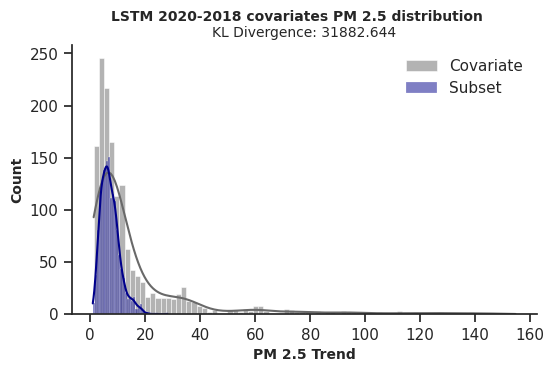

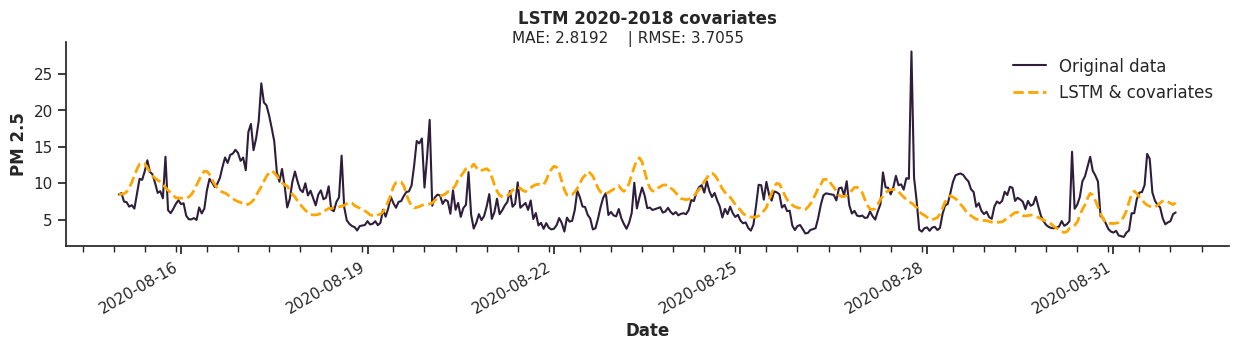

Plots for model: LSTM_2020-2017_covariates


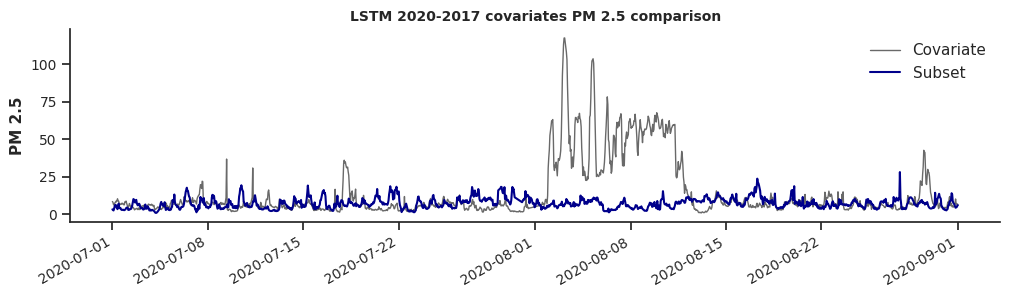

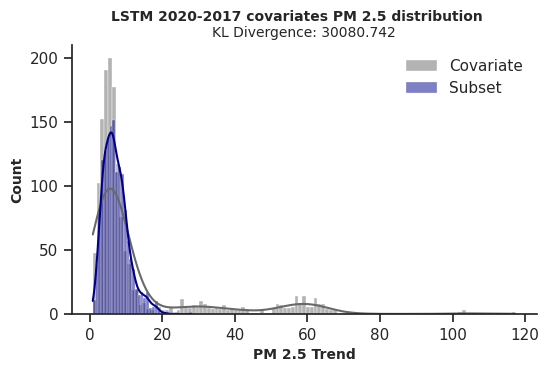

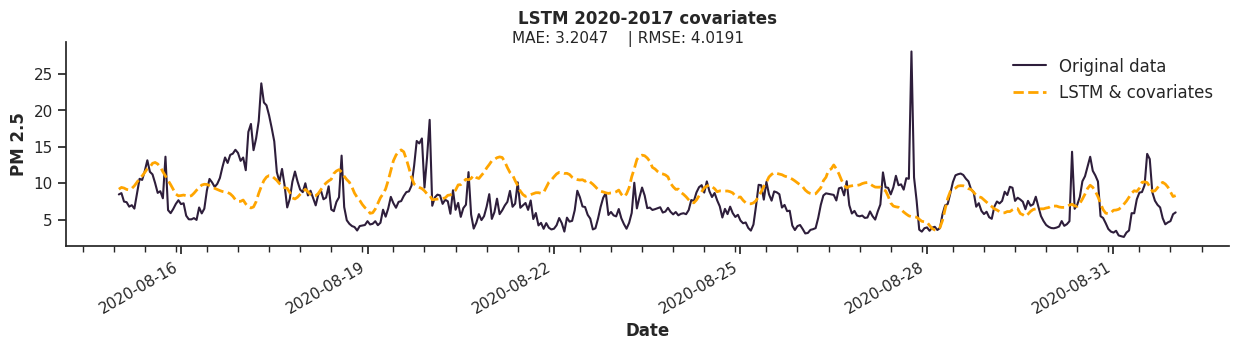

Plots for model: LSTM_2020-2016_covariates


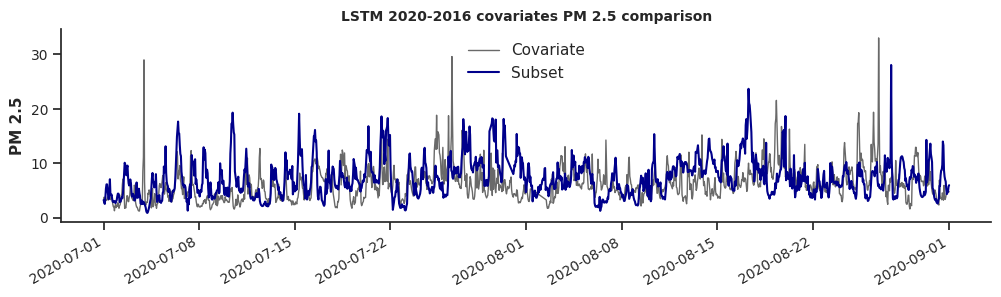

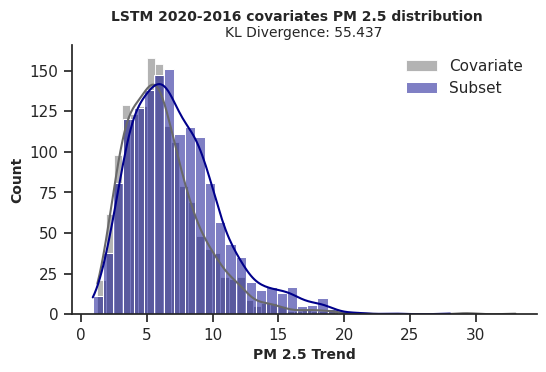

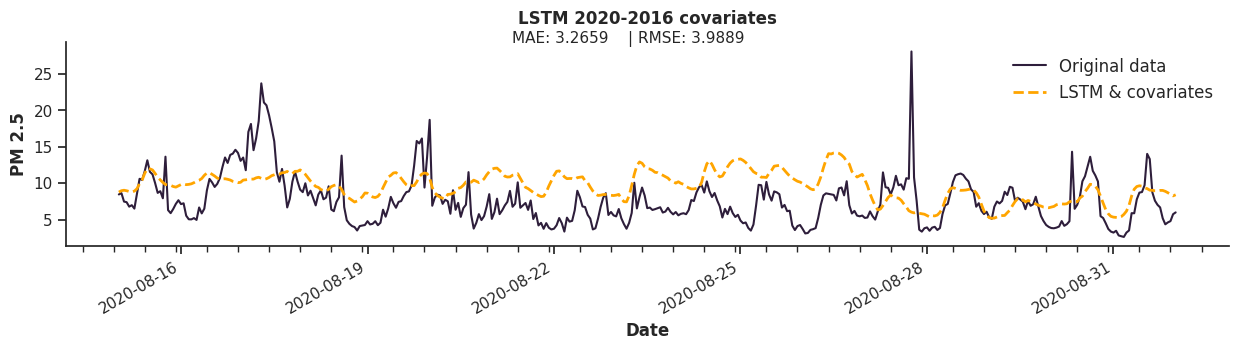

In [140]:
# Plotting results with past year covariates
from scipy.special import rel_entr

for model in results_dict.keys():
    val = results_dict[model]["val"]
    pred_val = results_dict[model]["pred_val"]

    val_df = pd.DataFrame({"DATE_PST": val.time_index, "PM 2.5": [i[0] for i in val.values()]}).set_index("DATE_PST", drop=True)
    pred_df = pd.DataFrame({"DATE_PST": pred_val.time_index, "PM 2.5": [i[0] for i in pred_val.values()]}).set_index("DATE_PST", drop=True)

    # Last column covariate
    last_cov_name = results_dict[model]["covariates"].columns[-1]
    last_cov = results_dict[model]["covariates"][last_cov_name]
    last_cov_df = last_cov[last_cov_name].pd_dataframe()

    print(f"Plots for model: {model}")

    plt.figure(figsize=(12, 2.5))
    last_cov.plot(label="Covariate", linewidth=1, color="dimgray")
    series.plot(label="Subset", linewidth=1.5, color="darkblue")
    plt.title(f'{str(model).replace("_", " ")} PM 2.5 comparison', fontsize=10, fontweight="bold")
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    plt.xlabel("")
    sns.despine()
    plt.show()

    # KL Divergence
    KL_Div = sum(rel_entr(last_cov_df[last_cov_name], subset.interpolate()))

    plt.figure(figsize=(6, 3.5))
    sns.histplot(last_cov_df[last_cov_name], label="Covariate", kde=True, color="dimgray")
    sns.histplot(subset, label="Subset", kde=True, color="darkblue")
    plt.suptitle(f'{str(model).replace("_", " ")} PM 2.5 distribution', fontsize=10, fontweight="bold")
    plt.title(f"KL Divergence: {KL_Div:.3f}", fontsize=10)
    plt.xlabel("PM 2.5 Trend", fontsize=10)
    plt.ylabel("Count", fontsize=10)
    plt.legend()
    sns.despine()
    plt.show()

    plot_compare(
        pred_df,
        val_df,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=False,
        fill=False,
        data_label="LSTM & covariates",
        data_missing_label="Original data",
        plot_title=str(model).replace("_", " "),
        plot_sup_title=f"MAE: {mae_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}\
    | RMSE: {rmse_score(val_df, pred_df, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
)

## Iterating through experimentation subsets
Filtering past covariates on KL Divergence threshold

In [145]:
stations = master_df["STATION"].unique()
stations

array(['Vancouver_Clark_Drive_PM25',
       'Vancouver_International_Airport_#2_PM25',
       'North_Vancouver_Mahon_Park_PM25',
       'North_Vancouver_Second_Narrows_PM25'], dtype=object)

In [147]:
# Experimentation subsets
subsets = {}
for station in stations:
    subsets[station] = {}
    for month, year in [(2, 2016), (11, 2017), (10, 2018), (8, 2020)]:
        subsets[station][f"{month}-{year}"] = master_df[master_df["STATION"] == station].loc[
    datetime(year, month-1, 1):datetime(year, month+1, 1), ["PM 2.5"]]

for station in subsets:
    print(station, subsets[station].keys())

# Darts timeseries64
for station in subsets:
    for month in subsets[station]:
        subsets[station][month] = TimeSeries.from_dataframe(subsets[station][month].interpolate())

Vancouver_Clark_Drive_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
Vancouver_International_Airport_#2_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Mahon_Park_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])
North_Vancouver_Second_Narrows_PM25 dict_keys(['2-2016', '11-2017', '10-2018', '8-2020'])


In [148]:
# Auxiliar plotting function
def dart_plot(train, val, station, month, pred=None, pred_label="predicted"):
    plt.figure(figsize=(12, 2.5))
    train.plot(label="training")
    val.plot(label="validation", linewidth=1, color="darkblue")
    if pred:
        pred.plot(label=pred_label, linewidth=1.5, color = "darkorange")
        plt.title(f"MAE: {mae(pred, val):.3f} | RMSE: {rmse(pred, val):.3f}", fontsize=10)
        plt.suptitle(f"{station} {month}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11, y=1.04)
    else:
        plt.title(f"{station} {month}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    plt.xlabel("")
    sns.despine()
    plt.show()

In [159]:
subsets["North_Vancouver_Mahon_Park_PM25"]["2-2016"].time_index.min()

Timestamp('2016-01-01 01:00:00', freq='H')

In [158]:
for year in range(2016, 2018):
    print(year)

2016
2017


In [167]:
# Iterating on subsets
for station in subsets:
    for month in subsets[station]:
        series = subsets[station][month]
        train, val = series.split_before(0.75)

        ## Creating month, day-of-week, and hour covariates
        # Month covariates
        month_series = datetime_attribute_timeseries(
            series, attribute="month", one_hot=True
        )

        # Weekday covariates
        weekday_series = datetime_attribute_timeseries(
            series, attribute="weekday", one_hot=True
        )

        # Hour covariates
        hour_series = datetime_attribute_timeseries(
            series, attribute="hour", one_hot=False
        )
        # Scaling hour covariates
        hour_series = Scaler().fit_transform(hour_series)

        # Stacking covariates
        covariates = month_series.stack(weekday_series)
        covariates = covariates.stack(hour_series)

        ## Creating previous years covariates
        past_covariates = {}
        current_subset_year = subsets[station][month].time_index.min().year
        current_subset_month = subsets[station][month].time_index.min().month
        for year in reversed(range(2016, current_subset_year)):
            station_subset = master_df[master_df["STATION"] == station]
            past_covariates[year] = station_subset.loc[datetime(year, current_subset_month, 1):datetime(year, current_subset_month+2, 1), "PM 2.5"]
            print(f"Missing values on {year} covariate: {past_covariates[year].to_frame().isna().sum()}")
            past_covariates[year] = TimeSeries.from_dataframe(past_covariates[year].to_frame().interpolate())

            # display(subsets[station][month].pd_dataframe())
            # display(past_covariates[year].pd_dataframe())
            print(f"Concatenating past covariate for year {year}...")

            # KL Divergence
            KL_Div = sum(rel_entr(past_covariates[year].pd_series().interpolate(), subsets[station][month].pd_series().interpolate()))
            print(f"{station} {month} shape: {subsets[station][month].pd_dataframe().shape}")
            print(KL_Div)
            # covariates = covariates.concatenate(past_covariates[year], axis=1, ignore_time_axis=True)

Missing values on 2016 covariate: PM 2.5    12
dtype: int64
Concatenating past covariate for year 2016...
Vancouver_Clark_Drive_PM25 11-2017 shape: (1465, 1)
nan
Missing values on 2017 covariate: PM 2.5    19
dtype: int64
Concatenating past covariate for year 2017...
Vancouver_Clark_Drive_PM25 10-2018 shape: (1465, 1)
nan
Missing values on 2016 covariate: PM 2.5    19
dtype: int64
Concatenating past covariate for year 2016...
Vancouver_Clark_Drive_PM25 10-2018 shape: (1465, 1)
nan
Missing values on 2019 covariate: PM 2.5    14
dtype: int64
Concatenating past covariate for year 2019...
Vancouver_Clark_Drive_PM25 8-2020 shape: (1489, 1)
nan
Missing values on 2018 covariate: PM 2.5    5
dtype: int64
Concatenating past covariate for year 2018...
Vancouver_Clark_Drive_PM25 8-2020 shape: (1489, 1)
nan
Missing values on 2017 covariate: PM 2.5    3
dtype: int64
Concatenating past covariate for year 2017...
Vancouver_Clark_Drive_PM25 8-2020 shape: (1489, 1)
nan
Missing values on 2016 covariate:

### XGBoost

In [65]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

start_date = datetime(2020, 7, 1)   # Subset start date
end_date = datetime(2020, 9, 1)     # Subset end date
split_date = datetime(2020, 8, 15)  # Training/Validation split date

station_subset = master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"]
train = station_subset.loc[np.logical_and(station_subset.index > start_date, station_subset.index <= split_date)]
test = station_subset.loc[np.logical_and(station_subset.index > split_date, station_subset.index <= end_date)]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (1080, 5)
Test shape: (408, 5)


In [66]:
# Datepart features
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    
    X = df[['hour','dayofweek','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [67]:
X_train, y_train = create_features(train.interpolate(), label="PM 2.5")
X_test, y_test = create_features(test.interpolate(), label="PM 2.5")

In [68]:
print(f"Training shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Training shape X: {X_test.shape}, y: {y_test.shape}")

Training shape X: (1080, 3), y: (1080,)
Training shape X: (408, 3), y: (408,)


In [73]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.005)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:7.51301	validation_1-rmse:7.86125
[10]	validation_0-rmse:7.18642	validation_1-rmse:7.50375
[20]	validation_0-rmse:6.87690	validation_1-rmse:7.16902
[30]	validation_0-rmse:6.58382	validation_1-rmse:6.85652
[40]	validation_0-rmse:6.30596	validation_1-rmse:6.56475
[50]	validation_0-rmse:6.04272	validation_1-rmse:6.29257
[60]	validation_0-rmse:5.79350	validation_1-rmse:6.03989
[70]	validation_0-rmse:5.55725	validation_1-rmse:5.80960
[80]	validation_0-rmse:5.33360	validation_1-rmse:5.60002
[90]	validation_0-rmse:5.12216	validation_1-rmse:5.40776
[100]	validation_0-rmse:4.92239	validation_1-rmse:5.22796
[110]	validation_0-rmse:4.73296	validation_1-rmse:5.06259
[120]	validation_0-rmse:4.55402	validation_1-rmse:4.91188
[130]	validation_0-rmse:4.38487	validation_1-rmse:4.77407
[140]	validation_0-rmse:4.22448	validation_1-rmse:4.64790
[150]	validation_0-rmse:4.07279	validation_1-rmse:4.53436
[160]	validation_0-rmse:3.92916	validation_1-rmse:4.42865
[170]	validation_0-rmse:3

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

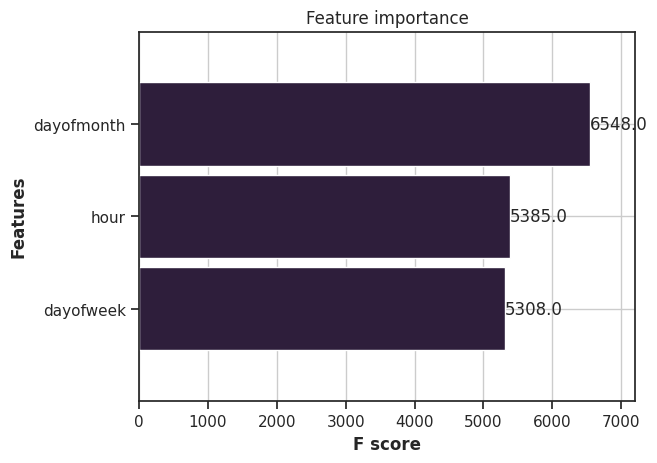

In [74]:
_ = plot_importance(reg, height=0.9)

In [75]:
test["Prediction"] = reg.predict(X_test)
test_train = pd.concat([test, train], sort = False)

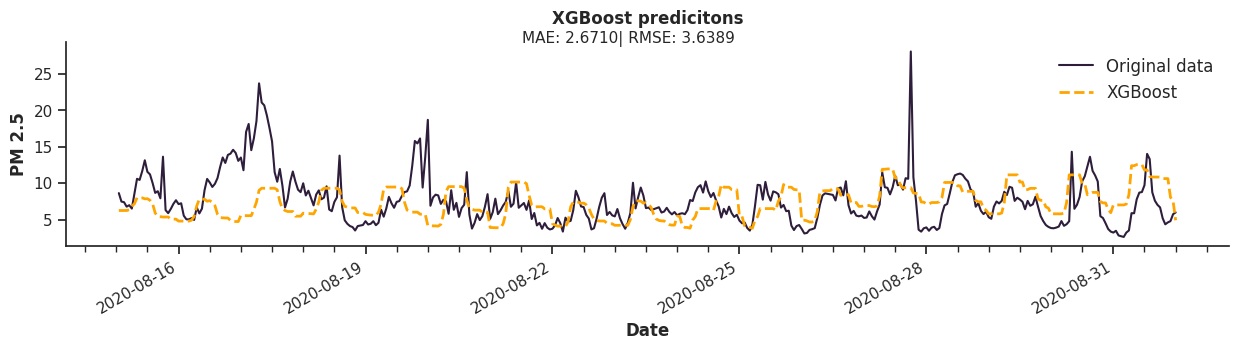

In [89]:
plot_compare(
    test,
    test,
    value="Prediction",
    value_missing="PM 2.5",
    missing_only=False,
    fill=False,
    data_label="XGBoost",
    data_missing_label="Original data",
    plot_title="XGBoost predicitons",
    plot_sup_title=f"MAE: {np.mean(np.abs(test['PM 2.5'] - test['Prediction'])):.4f}\
| RMSE: {np.sqrt(np.mean((test['PM 2.5'] - test['Prediction']) ** 2)):.4f}",
    figsize=(15, 3)
)

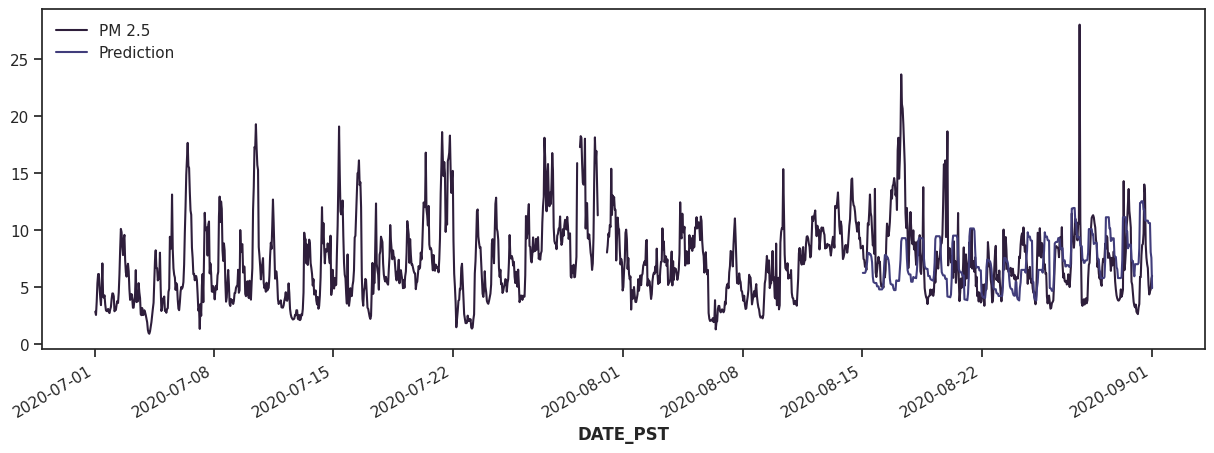

In [77]:
_ = test_train[["PM 2.5", "Prediction"]].plot(figsize=(15, 5))